In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from sklearn.metrics import classification_report, accuracy_score
import joblib  # Import joblib for saving the model
import os  # Import os for directory handling

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns (TLD removed)
features = [
    'CharacterContinuityRate', 'subDirLen', 'avgpathtokenlen',
    'NumberofDotsinURL', 'Entropy_URL', 'sub-Directory_LongestWordLength',
    'ldl_url', 'Entropy_Filename', 'Filename_LetterCount', 'ldl_filename',
    'delimeter_Count', 'charcompvowels', 'LongestPathTokenLength',
    'spcharUrl', 'NumberRate_URL', 'delimeter_path',
    'SymbolCount_Directoryname', 'NumberRate_FileName', 'Entropy_Domain'
]

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Convert 'url_type' to string since it's categorical
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

# Select only numeric features for checking infinite values
numeric_features = [f for f in features if f not in ['url_type']]

# Apply np.isfinite only to numeric features and filter rows
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X = df_cleaned[numeric_features]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Initialize the XGBoost classifier for binary classification
xgb_binary_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data for binary classification
xgb_binary_classifier.fit(X_train_bin, y_train_bin)

# Predict probabilities instead of direct class labels
y_train_pred_prob_bin = xgb_binary_classifier.predict_proba(X_train_bin)
y_test_pred_prob_bin = xgb_binary_classifier.predict_proba(X_test_bin)

# Set a custom threshold (0.7 for classifying as malicious)
threshold = 0.88

# Convert probabilities to class labels based on the custom threshold
y_train_pred_bin_threshold = (y_train_pred_prob_bin[:, 1] >= threshold).astype(int)
y_test_pred_bin_threshold = (y_test_pred_prob_bin[:, 1] >= threshold).astype(int)

# Evaluate the model with the custom threshold
print("Binary Classification Report (Benign vs Malicious) with Threshold - Training Data:")
print(classification_report(y_train_bin, y_train_pred_bin_threshold))
print("Binary Classification Accuracy with Threshold (Training):", accuracy_score(y_train_bin, y_train_pred_bin_threshold))

print("\nBinary Classification Report (Benign vs Malicious) with Threshold - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin_threshold))
print("Binary Classification Accuracy with Threshold (Test):", accuracy_score(y_test_bin, y_test_pred_bin_threshold))

# Specify the folder path where you want to save the model
folder_path = '../extension/ml'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the trained binary model to a file
joblib.dump(xgb_binary_classifier, os.path.join(folder_path, 'bin.pkl'))

# Summary of overall results
print("\nOverall Results Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin, y_train_pred_bin_threshold):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin_threshold):.4f}")


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Binary Classification Report (Benign vs Malicious) with Threshold - Training Data:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    299672
           1       1.00      0.87      0.93    156161

    accuracy                           0.96    455833
   macro avg       0.97      0.94      0.95    455833
weighted avg       0.96      0.96      0.95    455833

Binary Classification Accuracy with Threshold (Training): 0.955242380433185

Binary Classification Report (Benign vs Malicious) with Threshold - Test Data:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    128431
           1       0.99      0.87      0.93     66927

    accuracy                           0.95    195358
   macro avg       0.97      0.93      0.95    195358
weighted avg       0.96      0.95      0.95    195358

Binary Classification Accuracy with Threshold (Test): 0.9539819203718302

Overall Results Summary:
Binary C

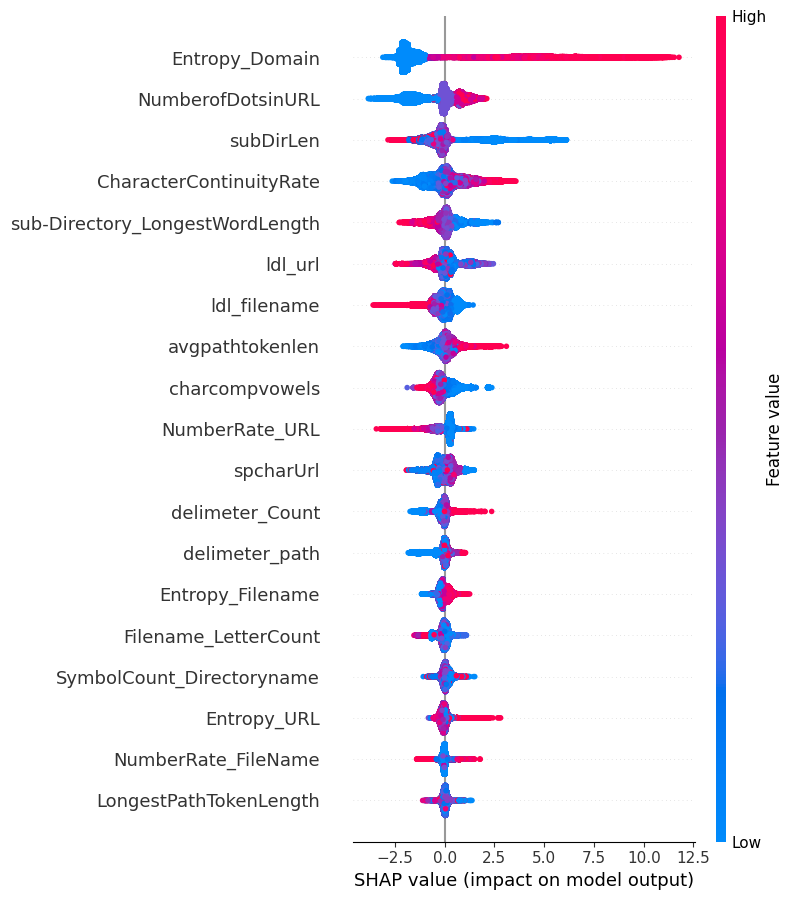

In [9]:
import shap  # Import SHAP

# SHAP Analysis for the binary classifier
explainer = shap.Explainer(xgb_binary_classifier)
shap_values = explainer(X_test_bin)

# Visualize SHAP values with a summary plot
shap.summary_plot(shap_values, X_test_bin, feature_names=X.columns)

# You can also visualize a specific prediction
# Example for the first test instance
shap.initjs()  # Initialize JS for SHAP visualization

# Use .values to get the SHAP values for the specific instance
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_bin.iloc[0], feature_names=X.columns)
